In [113]:
import os
import keras
import io
import csv

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
import numpy as np
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
import keras_metrics
from keras.utils.vis_utils import plot_model
import pydot

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D 

## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE


In [114]:
#set the directory 
hottransmsg_dir = 'C:\\Users\\vigupta\\OneDrive\\Learning\\DataScience\\DeepLearning\\CS230\\Project\Hinglish-Offensive-Text-Classification-master'
train_dir = os.path.join(hottransmsg_dir, 'train')
train_data = 'transmessages.csv'
label_data = 'labels.csv'
texts = []
labels = []
log_dir = './logs'

with open(os.path.join(train_dir, train_data), newline ='') as messageData:
    reader = csv.reader(messageData)
    for row in reader:
        message = (''.join(row))
        texts.append(message)

with open(os.path.join(train_dir, label_data)) as labelData:
    reader = csv.reader(labelData)
    for row in reader:
        #label = (''.join(row))
        labels.append(row)


In [116]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
labells = np_utils.to_categorical(encoded_Y)
print(labells[0,])


[1. 0. 0.]


In [117]:
'''
This code block is to be ignored; borrowed for a different project
try:
    for label_type in ['neg' , 'pos']:
        dir_name = os.path.join(train_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname[-4:] == '.txt':
                f = open(os.path.join(dir_name, fname), encoding="utf8")
                texts.append(f.read())
                f.close()
                if label_type == 'neg':
                    labels.append(0)
                else :
                    labels.append(1)
except:
    print("Error happened in reading and processing the dataset")
print('The length of the dataset is:', len(labels))            
print('The length of the texts is:', len(texts))            
'''

'\nThis code block is to be ignored; borrowed for a different project\ntry:\n    for label_type in [\'neg\' , \'pos\']:\n        dir_name = os.path.join(train_dir, label_type)\n        for fname in os.listdir(dir_name):\n            if fname[-4:] == \'.txt\':\n                f = open(os.path.join(dir_name, fname), encoding="utf8")\n                texts.append(f.read())\n                f.close()\n                if label_type == \'neg\':\n                    labels.append(0)\n                else :\n                    labels.append(1)\nexcept:\n    print("Error happened in reading and processing the dataset")\nprint(\'The length of the dataset is:\', len(labels))            \nprint(\'The length of the texts is:\', len(texts))            \n'

In [163]:
##Tokenizer, Sequencer and padding via Keras
maxlen = 100
training_samples = 2500
validation_samples = 500# len(labels) - training_samples #
max_words = 10000
num_filters = 64 
embedding_dim = 100
np.random.seed(1) 

#tokenize the data for the maxwords
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

#Generate the sequences on texts on the the data by tokenizer
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.'% len(word_index))

#Padding sequences (making them all equal)
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of the data tensor:' , data.shape)
print('Shape of the label tensor:' , labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labells[indices,:]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

print("Train length" , len(x_train))
print("Validation length" , len(x_val))

Found 7595 unique tokens.
Shape of the data tensor: (3189, 100)
Shape of the label tensor: (3189, 3)
Train length 2500
Validation length 500


In [164]:
y_val

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [165]:
np.random.seed(1) 
glove_dir = 'C:\\Users\\vigupta\\OneDrive\\Learning\\DataScience\\DeepLearning\\Glove'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
   # print(word)
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embedding_index))

Found 400000 word vectors


In [166]:
np.random.seed(1) 
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)       
#embedding_matrix[0:10, ]

(10000, 100)


In [173]:
np.random.seed(1) 
model = Sequential() 
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
#model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
#model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(Dense(64, activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(3, activation = 'softmax'))
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_22 (Glo (None, 64)                0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)              

In [178]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [179]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])

In [180]:

history = model.fit(x_train, y_train, epochs = 40, batch_size = 256, validation_data=[x_val, y_val])
model.save_weights('pre_trained_hot_model.h5')

C:\Users\vigupta\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 2500 samples, validate on 500 samples
Epoch 1/40
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1191 - acc: 0.9648 - val_loss: 0.7482 - val_acc: 0.7680
Epoch 2/40
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1126 - acc: 0.9644 - val_loss: 0.8207 - val_acc: 0.7800
Epoch 3/40
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1029 - acc: 0.9692 - val_loss: 0.8153 - val_acc: 0.7480
Epoch 4/40
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0948 - acc: 0.9692 - val_loss: 0.8325 - val_acc: 0.7580
Epoch 5/40
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0921 - acc: 0.9716 - val_loss: 0.8388 - val_acc: 0.7640
Epoch 6/40
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0862 - acc: 0.9732 - val_loss: 0.8622 - val_acc: 0.7680
Epoch 7/40
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0881 - acc: 0.9720 - val_loss: 0.9280 - val_acc: 0.7500
Epoch 8/40
2500

In [81]:
os.getcwd()

'C:\\Users\\vigupta\\OneDrive\\Learning\\DataScience\\DeepLearning\\CS230\\Project\\Hinglish-Offensive-Text-Classification-master'

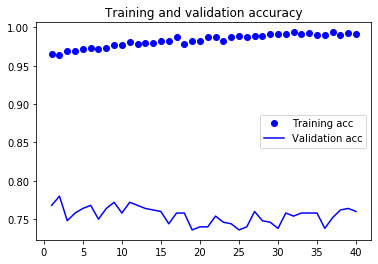

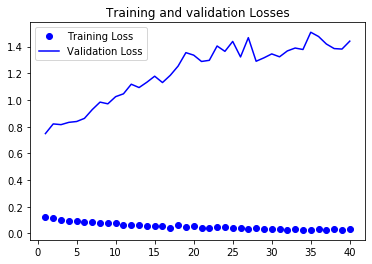

<Figure size 432x288 with 0 Axes>

In [183]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label ='Validation acc')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label ='Training Loss')
plt.plot(epochs, val_loss, 'b', label ='Validation Loss')
plt.title("Training and validation Losses")
plt.legend()
plt.figure()

plt.show()

In [75]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 100)


In [76]:
## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

In [51]:
tsne_embeddings = TSNE(n_components=2).fit_transform(weights)
plot_words(tsne_embeddings, 0, 2, 1)

NameError: name 'word_list' is not defined